In [3]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K
import keras_tuner




In [4]:
!pip install keras-tuner

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_path = r'/content/drive/MyDrive/RealWaste'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32,

)


Found 4752 files belonging to 9 classes.


In [7]:
class_names = sorted(os.listdir(data_path))  # Get folder names
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [8]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),   # Randomly flip images horizontally
    tf.keras.layers.RandomRotation(0.4),         # Randomly rotate images by up to 20%
    RandomZoom(0.4),             # Randomly zoom into images by 20%
    RandomBrightness(factor=0.4),        # Randomly increase the brightness
    RandomCrop(150,160)
])


# Apply augmentation to the training data
def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label



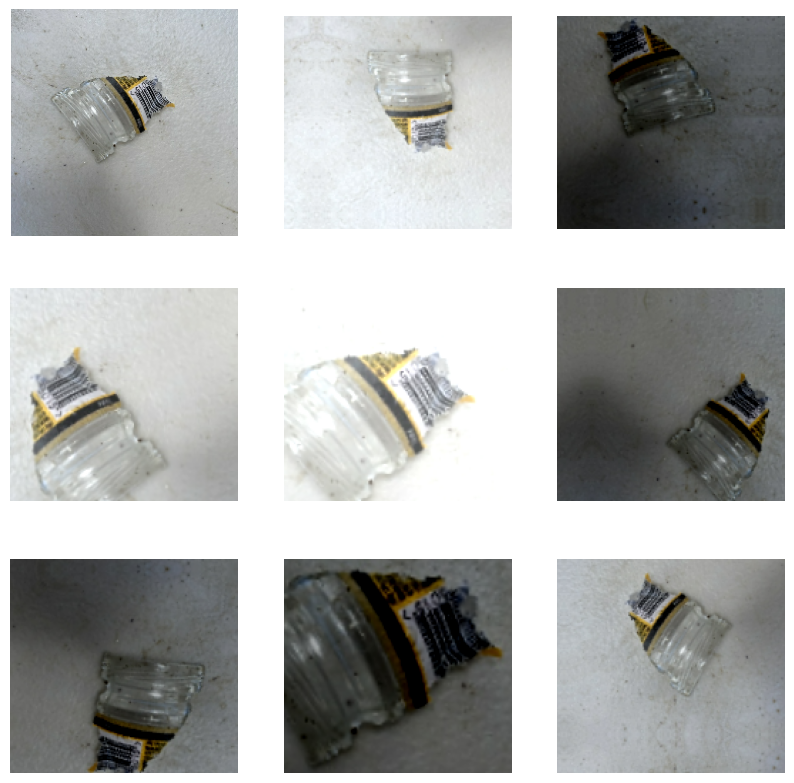

In [9]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]  # Select the first image in the batch

        # Apply augmentation multiple times to the same image
    augmented_images = [image]
    for _ in range(8):  # Create 8 augmented versions
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])

        # Display the original and augmented images
    for i in range(9):  # Display 9 images (1 original + 8 augmented)
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")

    plt.show()

# Call the function to visualize data augmentation
visualize_dataset(dataset, class_names)

In [10]:
def normalize_img(image, label):
    image = image/ 255.0  # Scale pixel values to [0, 1]
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label




In [11]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [12]:
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)   # 15% for validation
test_size = dataset_size - train_size - val_size  # 15% for testing

train_dataset = dataset.take(train_size).map(augment).map(normalize_img)

val_dataset = dataset.skip(train_size).take(val_size).map(normalize_img)
test_dataset = dataset.skip(train_size + val_size).map(normalize_img)

In [13]:
for images, labels in train_dataset.take(1):
    print(f"Min pixel value: {tf.reduce_min(images).numpy()}")
    print(f"Max pixel value: {tf.reduce_max(images).numpy()}")

Min pixel value: 0.0
Max pixel value: 1.0


TypeError: only length-1 arrays can be converted to Python scalars

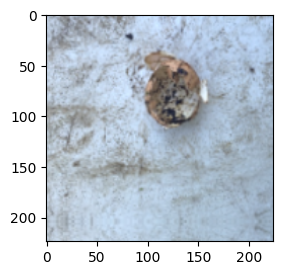

In [14]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Get one batch
        for i in range(9):  # Show 9 images
            ax = plt.subplot(3, 3, i + 1)
            img = images[i].numpy()
            plt.imshow(img)
            label_idx = int(labels[i].numpy())  # Extract class index from one-hot label
            plt.title(class_names[label_idx])
            plt.axis("off")
    plt.show()

# Visualize data augmentation results
visualize_dataset(train_dataset, class_names)

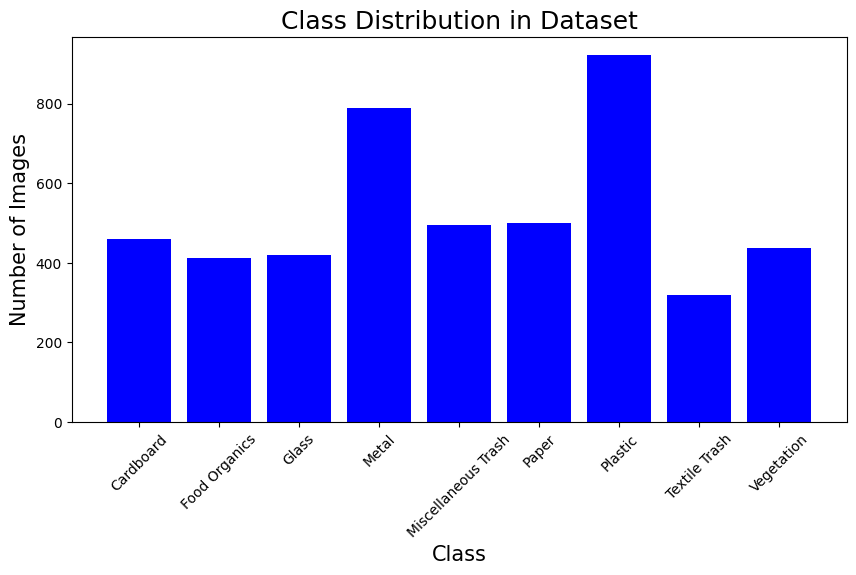

In [15]:


# Count number of images in each class
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [16]:
print("Number of batches in balanced_train_dataset:", tf.data.experimental.cardinality(train_dataset).numpy())


Number of batches in balanced_train_dataset: 104


In [17]:


print("Calculating class distribution from the original training dataset...")

label_counter = Counter()

# Use TensorFlow's efficient dataset mapping
def count_labels(batch):
    images, labels = batch
    if labels.ndim > 1:  # If one-hot encoded
        labels = tf.argmax(labels, axis=-1)
    return labels

# Aggregate labels using TensorFlow operations
all_labels = []

for batch in train_dataset:
    labels = count_labels(batch).numpy()  # Efficiently calculate batch labels
    all_labels.extend(labels.tolist())    # Append the list of labels

# Use Counter to get the class distribution
label_counter = Counter(all_labels)

print("Original class distribution:", dict(label_counter))



Calculating class distribution from the original training dataset...
Original class distribution: {6: 658, 2: 284, 8: 313, 3: 544, 4: 344, 7: 220, 1: 298, 0: 324, 5: 343}


In [ ]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.rot90(image)  # Use rotation to diversify
    return image

# Calculate the target number of samples (based on the dominant class)
max_samples = max(label_counter.values())
print(f"Target number of samples per class: {max_samples}")

# List to store augmented datasets
augmented_datasets = []

for cls in label_counter.keys():
    # Filter the minority class data
    minority_data = train_dataset.filter(lambda x, y: tf.reduce_any(tf.equal(y, cls)))
    num_samples = label_counter[cls]
    num_augmentations = max_samples - num_samples

    # Handle cases where no augmentation is needed
    if num_augmentations <= 0:
        augmented_datasets.append(minority_data)
        continue

    # Calculate number of full repeats and remaining samples
    repeats = num_augmentations // num_samples
    remainder = num_augmentations % num_samples

    # Augment the data exactly to match the target number of samples
    augmented_data = minority_data

    # Add full repeat batches
    for _ in range(repeats):
        augmented_batch = minority_data.map(lambda x, y: (augment_image(x), y))
        augmented_data = augmented_data.concatenate(augmented_batch)

    # Add the remaining samples if needed
    if remainder > 0:
        remainder_data = minority_data.take(remainder).map(lambda x, y: (augment_image(x), y))
        augmented_data = augmented_data.concatenate(remainder_data)

    # Combine original and augmented data
    combined_data = minority_data.concatenate(augmented_data)
    augmented_datasets.append(combined_data)

# Combine all augmented datasets with the original
balanced_train_dataset = augmented_datasets[0]
for ds in augmented_datasets[1:]:
    balanced_train_dataset = balanced_train_dataset.concatenate(ds)

print("Perfectly balanced training dataset prepared.")


In [36]:
import tensorflow as tf

def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.rot90(image)  # Use rotation to diversify
    return image

# Step 1: Calculate the target number of samples (based on the dominant class)
max_samples = max(label_counter.values())
print(f"Target number of samples per class: {max_samples}")

# Step 2: Prepare augmented datasets list
augmented_datasets = []

for cls in label_counter.keys():
    # Filter the minority class data
    minority_data = train_dataset.filter(lambda x, y: tf.reduce_any(tf.equal(y, cls)))
    num_samples = label_counter[cls]
    num_augmentations = max_samples - num_samples

    # Handle cases where no augmentation is needed
    if num_augmentations <= 0:
        augmented_datasets.append(minority_data)
        continue

    # Calculate number of repeats and remainder
    repeats = num_augmentations // num_samples
    remainder = num_augmentations % num_samples

    # Unbatch before augmentation to avoid nested batching
    minority_data = minority_data.unbatch()

    # Augment the data
    augmented_data = minority_data
    for _ in range(repeats):
        augmented_batch = minority_data.map(lambda x, y: (augment_image(x), y))
        augmented_data = augmented_data.concatenate(augmented_batch)

    # Augment the remaining samples
    if remainder > 0:
        remainder_data = minority_data.take(remainder).map(lambda x, y: (augment_image(x), y))
        augmented_data = augmented_data.concatenate(remainder_data)

    # Rebatch the augmented data to maintain consistency
    augmented_data = augmented_data.batch(32).prefetch(tf.data.AUTOTUNE)
    augmented_datasets.append(augmented_data)

# Step 3: Combine augmented data with the original
balanced_train_dataset = augmented_datasets[0]
for ds in augmented_datasets[1:]:
    balanced_train_dataset = balanced_train_dataset.concatenate(ds)

# Step 4: Manually set the number of batches to avoid unknown size
total_samples = sum([max_samples for _ in label_counter.keys()])
num_batches = total_samples // 32

balanced_train_dataset = balanced_train_dataset.apply(
    tf.data.experimental.assert_cardinality(num_batches)
)

print("Number of batches in balanced_train_dataset:", tf.data.experimental.cardinality(balanced_train_dataset).numpy())
print("Balanced training dataset prepared.")



Target number of samples per class: 3753
Number of batches in balanced_train_dataset: 1055
Balanced training dataset prepared.


In [34]:
# Calculate the total number of samples after augmentation
total_samples = sum(max(label_counter.values()) for _ in label_counter.keys())
print(f"Total samples after balancing: {total_samples}")
# Batch and prefetch the dataset properly
balanced_train_dataset = balanced_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Manually set the number of batches
num_batches = total_samples // 32

# Assert the cardinality to fix the unknown batch issue
balanced_train_dataset = balanced_train_dataset.apply(
    tf.data.experimental.assert_cardinality(num_batches)
)

print("Number of batches in balanced_train_dataset (after setting):", tf.data.experimental.cardinality(balanced_train_dataset).numpy())


Total samples after balancing: 33777
Number of batches in balanced_train_dataset (after setting): 1055


In [19]:


print("Calculating class distribution from the original training dataset...")

label_counter = Counter()

# Use TensorFlow's efficient dataset mapping
def count_labels(batch):
    images, labels = batch
    if labels.ndim > 1:  # If one-hot encoded
        labels = tf.argmax(labels, axis=-1)
    return labels

# Aggregate labels using TensorFlow operations
all_labels = []

for batch in balanced_train_dataset:
    labels = count_labels(batch).numpy()  # Efficiently calculate batch labels
    all_labels.extend(labels.tolist())    # Append the list of labels

# Use Counter to get the class distribution
label_counter = Counter(all_labels)

print("Original class distribution:", dict(label_counter))


Calculating class distribution from the original training dataset...
Original class distribution: {6: 3753, 1: 1665, 0: 1857, 4: 1907, 3: 3126, 7: 1270, 5: 1939, 2: 1646, 8: 1781}


In [30]:
for images, labels in balanced_train_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 9)


In [ ]:
import matplotlib.pyplot as plt

def visualize_augmented_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))

    # Get one batch from the dataset
    for images, labels in dataset.take(1):
        # Iterate over images in the batch
        for i in range(min(9, len(images))):  # Display at most 9 images
            ax = plt.subplot(3, 3, i + 1)
            img = images[i].numpy()  # Convert the image to a numpy array

            # If the label is one-hot encoded, convert it to class index
            if isinstance(labels[i], np.ndarray) and labels[i].ndim > 0:
                label = np.argmax(labels[i].numpy())
            else:
                label = int(labels[i].numpy())

            plt.imshow(img)
            plt.title(class_names[label])
            plt.axis("off")
    plt.show()

# Visualize the augmented data
visualize_augmented_dataset(balanced_train_dataset, class_names)


In [ ]:



def plot_class_distribution(label_counter, title):
    plt.figure(figsize=(8, 5))
    plt.bar(label_counter.keys(), label_counter.values(), color='blue')
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.show()

# Step 1: Class distribution before oversampling
print("Class distribution before oversampling:")
plot_class_distribution(label_counter, "Class Distribution Before Oversampling")

# Step 2: Calculate the class distribution after oversampling
balanced_label_counter = Counter()
for _, label in balanced_train_dataset.unbatch().as_numpy_iterator():
    label = int(label)  # Ensure the label is a scalar integer
    balanced_label_counter[label] += 1

print("Class distribution after oversampling:", dict(balanced_label_counter))
plot_class_distribution(balanced_label_counter, "Class Distribution After Oversampling")


In [ ]:
# Iterate over batches of the training dataset
train_labels = []

# Use .as_numpy_iterator() to convert the TensorFlow dataset to numpy
for batch in balanced_train_dataset.as_numpy_iterator():
    labels = batch[1]  # Extract the labels (second element of the batch)

    # If labels are one-hot encoded, convert to class indices
    if labels.ndim > 1:
        labels = np.argmax(labels, axis=1)  # Convert one-hot to class indices

    train_labels.extend(labels)  # Add the labels to the list

# Convert the list of labels into a numpy array
train_labels = np.array(train_labels)

# Compute class weights based on the training labels
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print out class weights (for reference)
print("Class weights:", class_weights_dict)


In [ ]:

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss for multi-class classification with one-hot labels.
    """
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)

    return loss

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [37]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model



# Build the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dense(9, activation="softmax")  # Adjust for the number of classes
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss= "categorical_crossentropy",
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss",  # Monitor the validation loss
                               patience=3,  # Number of epochs to wait for improvement
                               restore_best_weights=True,  # Restore the best model weights when stopping
                               verbose=1)  # Print messages when stopping

history = model.fit(balanced_train_dataset, validation_data=val_dataset, epochs=20,  callbacks=[early_stopping])



Epoch 1/20
  26/1055 ━━━━━━━━━━━━━━━━━━━━ 3:26 200ms/step - accuracy: 0.1026 - loss: 2.4999

KeyboardInterrupt: 

In [ ]:
# Get true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Get predicted probabilities
    y_true.extend(labels.numpy())  # Directly extend with integer labels
    y_pred_probs.extend(preds)  # Store predicted probabilities

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

print("True labels shape:", y_true.shape)
print("Predicted labels shape:", y_pred.shape)


In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
# Fine-tuning (optional)
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze first 100 layers
    layer.trainable = True

# Recompile after unfreezing
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss= "sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Train again on the small batch
history_fine_tune = model.fit(train_dataset, validation_data=val_dataset, epochs=50, class_weight=class_weights_dict,callbacks=[early_stopping] )

In [ ]:
def plot_hist(history_fine_tune):
    plt.plot(history_fine_tune.history["accuracy"])
    plt.plot(history_fine_tune.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history_fine_tune)

In [ ]:
# Get true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Get predicted probabilities
    y_true.extend(labels.numpy())  # Directly extend with integer labels
    y_pred_probs.extend(preds)  # Store predicted probabilities

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

print("True labels shape:", y_true.shape)
print("Predicted labels shape:", y_pred.shape)


In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:

# Convert true labels to one-hot encoding
num_classes = 9  # Adjust to your number of classes
y_true_one_hot = to_categorical(y_true, num_classes)

# Plot ROC Curve for each class
plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:



def build_model(hp):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = hp.Boolean('trainable', default=False)  # Fine-tuning option

    # Fine-tuning option
    trainable = hp.Boolean('trainable', default=False)  # Start with frozen model
    base_model.trainable = trainable

    # Unfreeze the top N layers if trainable
    if trainable:
        num_unfrozen_layers = hp.Int("unfreeze_layers", min_value=10, max_value=30, step=5)
        for layer in base_model.layers[-num_unfrozen_layers:]:
            layer.trainable = True

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(hp.Float("dropout_rate", min_value=0.3, max_value=0.7, step=0.1)),
        layers.Dense(hp.Int("units", min_value=128, max_value=512, step=64), activation="relu"),
        layers.Dense(9, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", [1e-4, 1e-5, 1e-6])),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [ ]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    directory="hyperparameter_tuning",
    project_name="efficientnet_tuning"
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

In [ ]:
tuner.search(final_train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping, lr_scheduler])

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best Learning Rate: {best_hp.get('learning_rate')}")
print(f"Best Dropout Rate: {best_hp.get('dropout_rate')}")
print(f"Best Number of Units: {best_hp.get('units')}")
print(f"Trainable Base Model: {best_hp.get('trainable')}")


In [ ]:
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    final_train_dataset,
    validation_data=val_dataset,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler]
)


In [ ]:
tuner.results_summary()


In [ ]:
from sklearn.metrics import classification_report

# Get true labels and predicted probabilities
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # One-hot to class index
    y_pred_probs.extend(preds)

# Convert to arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Get predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)


In [ ]:


print(classification_report(y_true, y_pred, zero_division=0))


In [ ]:
# Evaluate on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
